# OpenAI Gym


In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

import gymnasium as gym

from extravaganza.dynamical_systems import Gym

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpmlei1rah
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpmlei1rah/_remote_module_non_scriptable.py


## System
Here, we work with games in the OpenAI gym, such as `MountainCarContinuous-v0`, in which we supply a value in `[-1, 1]` as a control to push a car left or right up a mountain. The tricky thing about this environment is that you first have to push the car up the left to gain momentum, even though the goal is on the right.

Another good environment is the `CartPole` enviroment (left and right bumps on a cart to keep an inverted pendulum upright), whose continuous analog is also displayed below.

We make use of **only the reward signal or cost function** to train, not using any state observation.

MountainCar | CartPole
- | - 
![mountaincar.gif](https://www.gymlibrary.dev/_images/mountain_car.gif) | ![cart_pole.gif](https://www.gymlibrary.dev/_images/cart_pole.gif)

## Hyperparameters

In [2]:
name = 'gymtesty'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 20000  # total timesteps
    T0 = 5000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # when to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 1
    ds = 4
    env_name = 'CartPoleContinuous-v1'  
    # env_name = 'MountainCarContinuous-v0'
    make_system = lambda : Gym(env_name=env_name, repeat=1, max_episode_len=2000, seed=SYSTEM_SEED)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------
    
    dl = 3
    
    observable = TimeDelayedObservation(hh = 3, state_dim=ds, control_dim=du, 
                                        use_states=False, use_controls=True, 
                                        use_costs=True, use_cost_diffs=False,
                                        use_time=False)

#     observable = PartialObservation(obs_dim = 3, state_dim=ds, seed=SYSTEM_SEED)
#     observable = FullObservation(state_dim=ds)
    
#     if env_name == 'CartPoleContinuous-v1':
#         assert ds == 4 and du == 1
#         def cartpole_obs_func(traj: Trajectory):
#             obs = traj.x[-1]
#             obs.at[0].set(obs[0] / 10)
#             obs.at[1].set(obs[1] / 100)
#             obs.at[3].set(obs[3] / 100)
#             return obs
#         observable = Observable(obs_func=cartpole_obs_func, obs_dim=ds)
        
    do = observable.obs_dim
    
    exploration_args = {'scales': 0.1, 'avg_len': 3,}
    sysid_args = {
        'obs_dim': do,
        'control_dim': du,

        'exploration_args': {'random 0.6': exploration_args,
                             'impulse 0.4': exploration_args,
                            },

        'method': 'nn',
        'AB_method': 'regression',
        'deterministic': True,
        'isometric': False,

        'sigma': 0,
        'depth': 8,
        'num_iters': 8000,
        'batch_size': 256,
        'lifter_lr': 0.001,
        'hh': 5,

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 4  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.0004, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.0004, betas=(0.9, 0.999))
#     m0_update_rescaler = lambda : FIXED_RESCALE(alpha=-0.01, beta=0.999)
    k_update_rescaler = lambda : ADAM(0.0004, betas=(0.9, 0.999))
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.4, beta=0.6)

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0, 0.01, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'seed': CONTROLLER_SEED
    }
    
    make_controllers = {
#         'Lifted LQR': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=LQR(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted HINF': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=HINF(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
#         'Lifted GPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=GPC(sysid.A, sysid.B, decay=False, lr_scale=0.01, H=10), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, **sysid_args), T0=T0),
        'Lifted EvanBPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=EvanBPC(sysid.A, sysid.B, **nonlinear_bpc_args), lifter=sysid),
                                          sysid=Lifter(state_dim=dl, **sysid_args), T0=T0)
    }

    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [3]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Lifted EvanBPC
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger

INFO: 		nontrivial: 	0.0006078083509055432
INFO: 		simplification: 	0.00041645260011137
INFO: 		simplification 0: 	0.0006329828064190224
INFO: 		simplification 1: 	0.0010040308862517121
INFO: 		simplification 2: 	0.0016024510757415556
INFO: 		simplification 3: 	0.0025955825702112635
INFO: 		simplification 4: 	0.004084257192298537
INFO: mean loss for iters 6400 - 7200:
INFO: 		guess the control: 	4.364807077422483e-05
INFO: 		l2 linearization 0: 	0.00014929210610716836
INFO: 		l2 linearization 1: 	0.00042627601847925687
INFO: 		l2 linearization 2: 	0.0009273852712794906
INFO: 		l2 linearization 3: 	0.0017312633198162076
INFO: 		l2 linearization 4: 	0.002982055460597621
INFO: 		nontrivial: 	0.0005927421503292862
INFO: 		simplification: 	0.00043426574951809015
INFO: 		simplification 0: 	0.000649737051971897
INFO: 		simplification 1: 	0.00100920441425842
INFO: 		simplification 2: 	0.0015935513970180182
INFO: 		simplification 3: 	0.0025640196925814963
INFO: 		simplification 4: 	0.0039950782

regression (ret) :


 25%|███████████████████▎                                                         | 5000/20000 [00:33<20:03, 12.47it/s, control=-.00335, cost=0.0274]

||A||_op = 1.2626745700836182
||B||_F = 1.2659446001052856
||A-BK||_op = 1.4814356565475464
eig(A) = [0.9650879  0.17856526 0.00598541]
svd(B) = [1.2659446]

moments :
||A||_op = 0.9606112241744995
||B||_F = 0.006941723171621561
||A-BK||_op = 0.9606091976165771
eig(A) = [0.7661509  0.20729831 0.00541491]
svd(B) = [0.00694172]



100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:54<00:00, 114.50it/s, control=-.166, cost=0.0334]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 176.8348231249256 seconds


In [4]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [5]:
def plot_gym(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'true states', label=method, plot_idx=2)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        
#         stats.plot(ax[2, 0], 'states', label=method, plot_norm=True)  # norm of the "state"
        for j in range(3):
            stats.plot(ax[2, 0], 'states', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(ax[2, 1], 'linearization', label='linearization')  # various nn losses
        stats.plot(ax[2, 1], 'simplification', label='simplification')
        stats.plot(ax[2, 1], 'reconstruction', label='reconstruction')
        stats.plot(ax[2, 1], 'controllability', label='controllability')
            
        i_ax = ax[n + i // 2, i % 2]
        for j in range(3):
            stats.plot(ax[0, 1], 'disturbances', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('true states'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 3)
    _ax = ax[2, 0]; _ax.set_title('reconstructed states'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('nn losses'); _ax.legend()  
    pass

### Plot
note: for cartpole we want controls to be in same direction as pole angle. if we play negative control, angle goes more positive. so, when met with positive angle, we should play positive control.

<Figure size 640x480 with 0 Axes>

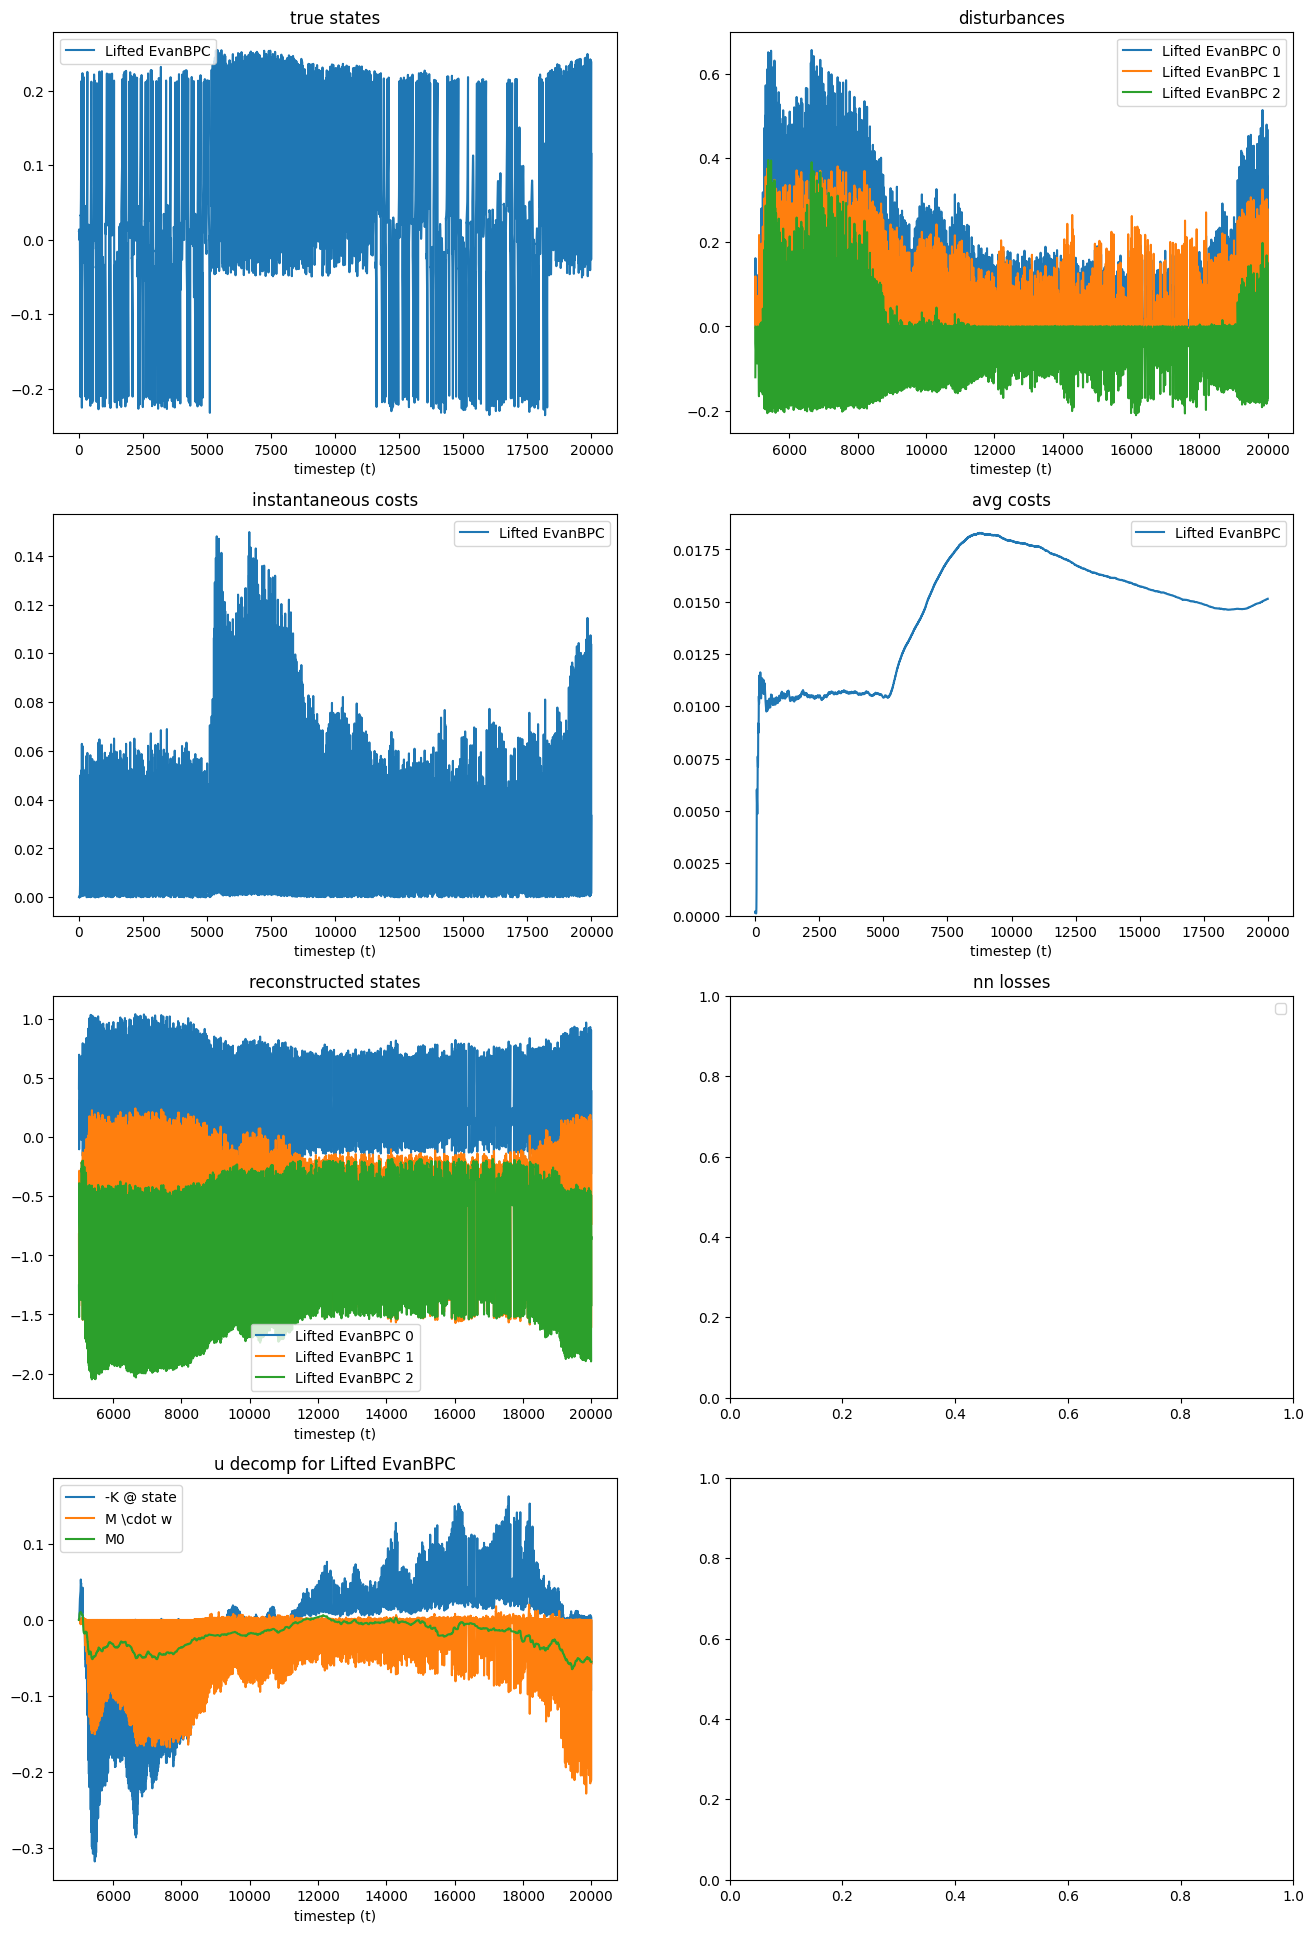

In [6]:
plot_gym(experiment)

### a